<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Robot-class" data-toc-modified-id="Robot-class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>Robot</code> class</a></span></li><li><span><a href="#Reinforcement-Learning-Problem-for-Controlling-the-Robot" data-toc-modified-id="Reinforcement-Learning-Problem-for-Controlling-the-Robot-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reinforcement Learning Problem for Controlling the Robot</a></span></li><li><span><a href="#Reinforcement-Learning-Training-Algorithm" data-toc-modified-id="Reinforcement-Learning-Training-Algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reinforcement Learning Training Algorithm</a></span></li><li><span><a href="#Required-Experiments" data-toc-modified-id="Required-Experiments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Required Experiments</a></span><ul class="toc-item"><li><span><a href="#Good-parameter-values" data-toc-modified-id="Good-parameter-values-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Good parameter values</a></span></li><li><span><a href="#Create-robot-with-four-links-of-lengths,-4,-3,-3,--and-2." data-toc-modified-id="Create-robot-with-four-links-of-lengths,-4,-3,-3,--and-2.-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Create robot with four links of lengths, 4, 3, 3,  and 2.</a></span></li><li><span><a href="#Increase-number-of-valid-actions" data-toc-modified-id="Increase-number-of-valid-actions-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Increase number of valid actions</a></span></li></ul></li><li><span><a href="#Extra-Credit" data-toc-modified-id="Extra-Credit-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extra Credit</a></span></li></ul></div>

<font size=5>A6 Reinforcement Learning to Control a Robot</font> 

In this assignment, you will play with a simulation of a two-dimensional robot arm with multiple links and joints. You will train a neural network to approximate the Q function.

The state of the arm is just the angles of each joint.  To remove the huge difference between joint angles of 359 degrees and 1 degree as a joint moves, we will represent each joint angle with two values, the sine and cosine of the angle, as the state input to the neural network. Valid actions on each step will be $-0.1$, $0$, and $+0.1$ applied to each joint.

# `Robot` class

Here is an implementation of the robot simulation.

In [26]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sys
import itertools  # for product (cross product)
from math import pi
from IPython.display import display, clear_output

Now import your `NeuralNetwork` regression class that uses `numpy` and has the `scg` optimizer available.

In [27]:
import neuralnetworksA4 as nn  # where you implement the NeuralNetwork class

In [28]:
class Robot():

    def __init__(self, link_lengths):
        self.n_links = len(link_lengths)
        self.record_angles = False
        self.angles = []
        self.link_lengths = np.array(link_lengths)
        self.joint_angles = np.zeros(self.n_links)
        self.points = [[10, 10] for _ in range(self.n_links + 1)]
        self.lim = sum(link_lengths)
        self.update_points()
        self.goal = None

    def set_goal(self, g):
        self.goal = g

    def dist_to_goal(self):
        return np.sqrt(np.sum((self.goal - self.end_effector)**2))
    
    def update_joints(self, joint_angles):
        self.joint_angles = joint_angles
        self.update_points()

    def add_to_joints(self, joint_angle_deltas):
        self.joint_angles += joint_angle_deltas
        too_high = self.joint_angles > 2 * pi
        self.joint_angles[too_high] = self.joint_angles[too_high] - 2 * pi
        too_low = self.joint_angles < 0
        self.joint_angles[too_low] = self.joint_angles[too_low] + 2 * pi
        if self.record_angles:
            self.angles.append(self.joint_angles * 180 / pi)
        self.update_points()

    def update_points(self):
        for i in range(1, self.n_links + 1):
            self.points[i][0] = (self.points[i - 1][0]
                                 + self.link_lengths[i - 1] * np.cos(np.sum(self.joint_angles[:i])))
            self.points[i][1] = (self.points[i - 1][1] +
                                 self.link_lengths[i - 1] * np.sin(np.sum(self.joint_angles[:i])))
        self.end_effector = np.array(self.points[self.n_links]).T

    def get_angles(self):
        return self.joint_angles
    

    def plot(self, style):
        for i in range(self.n_links + 1):
            if i is not self.n_links:
                plt.plot([self.points[i][0], self.points[i + 1][0]],
                         [self.points[i][1], self.points[i + 1][1]], style)
            plt.plot(self.points[i][0], self.points[i][1], 'k.')
        plt.axis('off')
        plt.axis('square')
        plt.xlim([-1, 21])
        plt.ylim([-1, 21])

    def animate(self, n_steps, Qnet=None, show_all_steps=False):
        fig = plt.figure(figsize=(8, 8))
        
        for i in range(n_steps):
            if not show_all_steps:
                fig.clf()
            plt.scatter(self.goal[0], self.goal[1], s=80)
            if Qnet:
                action, Qvalue = epsilon_greedy(self, Qnet, valid_actions, epsilon=0)
            else:
                action = [0.1] * self.n_links
            self.add_to_joints(action)
            style = 'b-' if show_all_steps and i+1 == n_steps else 'r-'
            self.plot(style)
            
            if not show_all_steps:
                clear_output(wait=True)
                display(fig)
            
        if not show_all_steps:
            clear_output(wait=True)

To use this class, first instantiate a robot by specifying the number of links and the lengths of each link as a list.  Imagine the end of the last link of the robot has a gripper. Set the goal location for the gripper by calling `robot.set_goal()`.  

Then you can animate the robot for some number of steps.

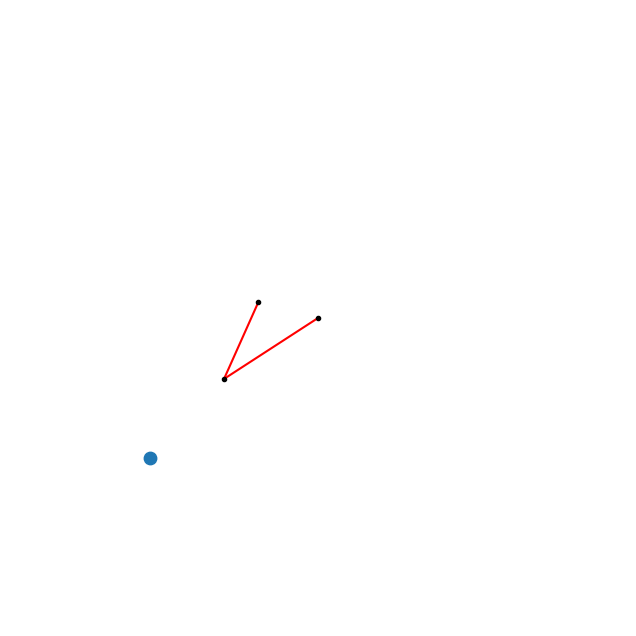

In [29]:
robot = Robot([4, 3])
robot.set_goal([4, 5])
robot.animate(100)

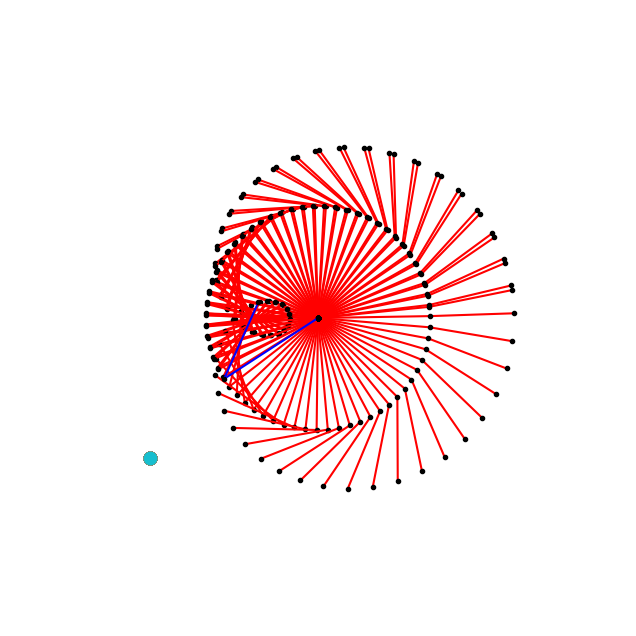

In [30]:
robot = Robot([4, 3])
robot.set_goal([4, 5])
robot.animate(100, show_all_steps=True)

# Reinforcement Learning Problem for Controlling the Robot

To define the reinforcement learning problem for controlling this robot, and trying to move the gripper as close to the goal as you can, we need to define the three main functions that define a reinforcement learning problem.  These are pretty easy with the functions available to us in the `Robot` class.  We will also need a function to represent the joint angles as sines and cosines.

In [31]:
def angles_to_sin_cos(angles):
    return np.hstack((np.sin(angles), np.cos(angles)))


def initial_state(robot):
    robot.update_joints(np.random.uniform(-2 * pi, 2 * pi, size=(robot.n_links)))
    angles = robot.get_angles()
    state = angles_to_sin_cos(angles)
    return state


def next_state(robot, action):
    robot.add_to_joints(action)
    angles = robot.get_angles()
    state = angles_to_sin_cos(angles)
    return state


def reinforcement(robot):
    '''Objective is to move gripper to the goal location as quickly as possible.'''
    dist_to_goal = robot.dist_to_goal()
    return dist_to_goal

In [32]:
angles_to_sin_cos([0, pi/4, pi/2, pi, -pi])

array([ 0.00000000e+00,  7.07106781e-01,  1.00000000e+00,  1.22464680e-16,
       -1.22464680e-16,  1.00000000e+00,  7.07106781e-01,  6.12323400e-17,
       -1.00000000e+00, -1.00000000e+00])

In [33]:
initial_state(robot)

array([ 0.22758398, -0.7873661 , -0.97375846,  0.61648571])

In [34]:
next_state(robot, [-1, 1])

array([ 0.94235364,  0.09333912, -0.33461862,  0.99563438])

In [35]:
reinforcement(robot)

11.98239089845881

Now we need our two workhorse functions, `epsilon_greedy` and `make_samples`.

In [36]:
def epsilon_greedy(robot, Qnet, valid_actions, epsilon):
    state = angles_to_sin_cos(robot.get_angles())
    
    if np.random.uniform() < epsilon:
        
        # Random Move
        actioni = np.random.randint(valid_actions.shape[0])
        action = valid_actions[actioni]
        
    else:
        # Greedy Move
        
        Qs = [Qnet.use(np.hstack((state, a)).reshape((1, -1))) for a in valid_actions]
        ai = np.argmin(Qs)
        action = valid_actions[ai]
        
    Q = Qnet.use(np.hstack((state, action)).reshape((1, -1)))
    
    return action, Q

In [37]:
def make_samples(robot, Qnet, initial_state_f, next_state_f, reinforcement_f,
                 valid_actions, n_samples, epsilon):

    X = np.zeros((n_samples, Qnet.n_inputs))
    R = np.zeros((n_samples, 1))
    Qn = np.zeros((n_samples, 1))

    state = initial_state_f(robot)
    state = next_state_f(robot, [0] * robot.n_links)  # 0 action for all joints
    action, _ = epsilon_greedy(robot, Qnet, valid_actions, epsilon)

    # Collect data from numSamples steps
    for step in range(n_samples):
        
        next_state = next_state_f(robot, action)
        r = reinforcement_f(robot)
        next_action, next_Q = epsilon_greedy(robot, Qnet, valid_actions, epsilon)
        
        X[step, :] = np.hstack((state, action))
        R[step, 0] = r
        Qn[step, 0] = next_Q
        
        # Advance one time step
        state, action = next_state, next_action

    return (X, R, Qn)

# Reinforcement Learning Training Algorithm

In [38]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.X_means = np.array(Xmeans)
    Qnet.X_stds = np.array(Xstds)
    Qnet.T_means = np.array(Tmeans)
    Qnet.T_stds = np.array(Tstds)

def train(robot, n_hiddens_list, valid_actions, n_trials, n_steps_per_trial, n_scg_iterations,
          final_epsilon, gamma=0.8):

    epsilon_decay = np.exp(np.log(final_epsilon) / (n_trials))  # to produce this final value

    n_inputs = robot.n_links * 2 + robot.n_links
    
    Qnet = nn.NeuralNetwork(n_inputs, n_hiddens_list, 1)

    means_state = [0] * robot.n_links * 2
    means_actions = [0] * robot.n_links
    stds_states = [0.5] * robot.n_links * 2
    stds_actions = [1.0] * robot.n_links
    setup_standardization(Qnet, means_state + means_actions, stds_states + stds_actions, [0], [1])

    epsilon = 1         # initial epsilon value
    epsilon_trace = []
    r_mean_trace = []
    r_trace = np.zeros((n_trials * n_steps_per_trial, 1))
     
    for trial in range(n_trials):

        # Collect n_steps_per_trial samples
        
        X, R, Qn = make_samples(robot, Qnet, initial_state, next_state, reinforcement, 
                                valid_actions, n_steps_per_trial, epsilon)
    
        # Train Qnet on these samples for n_scg_iterations
        Qnet.train(X, R + gamma * Qn, n_scg_iterations, method='scg')

        # Update the three traces
        epsilon_trace.append(epsilon)
        i = trial * n_steps_per_trial
        j = i + n_steps_per_trial
        r_trace[i:j, :] = R
        r_mean_trace.append(np.mean(R))
        
        # Decay epsilon
        epsilon *=  epsilon_decay
        epsilon = max(final_epsilon, epsilon)
        
#         if trial + 1 == n_trials or (trial + 1) % (n_trials // 10) == 0:
#             print(f'Trial {trial+1}: Mean R {r_mean_trace[-1]:.2f}')
             
    return Qnet, r_mean_trace, r_trace, epsilon_trace

In [40]:
robot = Robot([3., 3.])
robot.set_goal([5., 6.])

In [41]:
single_joint_actions = [-0.1, 0, 0.1]
valid_actions =  np.array(list(itertools.product(single_joint_actions, repeat=robot.n_links)))

In [42]:
robot

In [43]:
robot.n_links

2

In [44]:
n_hiddens_list = [50]
n_trials = 200
n_steps_per_trial = 1000
n_scg_iterations = 4
final_epsilon = 0.01
gamma = 0.9

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

SCG: Iteration 1 RMSE=2.07268
SCG: Iteration 2 RMSE=1.03649
SCG: Iteration 3 RMSE=0.52204
SCG: Iteration 4 RMSE=0.44103
SCG: Iteration 1 RMSE=2.55061
SCG: Iteration 2 RMSE=2.05552
SCG: Iteration 3 RMSE=0.96089
SCG: Iteration 4 RMSE=0.88955
SCG: Iteration 1 RMSE=2.10773
SCG: Iteration 2 RMSE=1.48843
SCG: Iteration 3 RMSE=1.28925
SCG: Iteration 4 RMSE=1.07667
SCG: Iteration 1 RMSE=3.77072
SCG: Iteration 2 RMSE=3.69155
SCG: Iteration 3 RMSE=3.08867
SCG: Iteration 4 RMSE=2.64940
SCG: Iteration 1 RMSE=3.96536
SCG: Iteration 2 RMSE=2.39010
SCG: Iteration 3 RMSE=2.14898
SCG: Iteration 4 RMSE=2.03168
SCG: Iteration 1 RMSE=3.55214
SCG: Iteration 2 RMSE=2.08260
SCG: Iteration 3 RMSE=1.69988
SCG: Iteration 4 RMSE=1.46887
SCG: Iteration 1 RMSE=2.93024
SCG: Iteration 2 RMSE=2.64154
SCG: Iteration 3 RMSE=2.20054
SCG: Iteration 4 RMSE=2.04854
SCG: Iteration 1 RMSE=2.64009
SCG: Iteration 2 RMSE=2.25437
SCG: Iteration 3 RMSE=1.95178
SCG: Iteration 4 RMSE=1.62987
SCG: Iteration 1 RMSE=2.80726
SCG: Itera

SCG: Iteration 1 RMSE=0.90056
SCG: Iteration 2 RMSE=0.88799
SCG: Iteration 3 RMSE=0.88551
SCG: Iteration 4 RMSE=0.87930
SCG: Iteration 1 RMSE=0.97863
SCG: Iteration 2 RMSE=0.96650
SCG: Iteration 3 RMSE=0.95632
SCG: Iteration 4 RMSE=0.94515
SCG: Iteration 1 RMSE=0.85372
SCG: Iteration 2 RMSE=0.84465
SCG: Iteration 3 RMSE=0.83888
SCG: Iteration 4 RMSE=0.82717
SCG: Iteration 1 RMSE=1.00200
SCG: Iteration 2 RMSE=0.97980
SCG: Iteration 3 RMSE=0.95793
SCG: Iteration 4 RMSE=0.93582
SCG: Iteration 1 RMSE=1.23448
SCG: Iteration 2 RMSE=1.17062
SCG: Iteration 3 RMSE=1.08061
SCG: Iteration 4 RMSE=1.02432
SCG: Iteration 1 RMSE=2.05362
SCG: Iteration 2 RMSE=1.45535
SCG: Iteration 3 RMSE=1.40964
SCG: Iteration 4 RMSE=1.27010
SCG: Iteration 1 RMSE=1.67597
SCG: Iteration 2 RMSE=1.43533
SCG: Iteration 3 RMSE=1.38976
SCG: Iteration 4 RMSE=1.37716
SCG: Iteration 1 RMSE=1.45145
SCG: Iteration 2 RMSE=1.29728
SCG: Iteration 3 RMSE=1.24659
SCG: Iteration 4 RMSE=1.23329
SCG: Iteration 1 RMSE=1.46079
SCG: Itera

SCG: Iteration 1 RMSE=0.52829
SCG: Iteration 2 RMSE=0.33661
SCG: Iteration 3 RMSE=0.32429
SCG: Iteration 4 RMSE=0.30612
SCG: Iteration 1 RMSE=0.44833
SCG: Iteration 2 RMSE=0.34113
SCG: Iteration 3 RMSE=0.33863
SCG: Iteration 4 RMSE=0.28944
SCG: Iteration 1 RMSE=0.48953
SCG: Iteration 2 RMSE=0.29331
SCG: Iteration 3 RMSE=0.28492
SCG: Iteration 4 RMSE=0.26351
SCG: Iteration 1 RMSE=0.42181
SCG: Iteration 2 RMSE=0.27685
SCG: Iteration 3 RMSE=0.27198
SCG: Iteration 4 RMSE=0.23733
SCG: Iteration 1 RMSE=0.44860
SCG: Iteration 2 RMSE=0.31716
SCG: Iteration 3 RMSE=0.30869
SCG: Iteration 4 RMSE=0.27155
SCG: Iteration 1 RMSE=0.28488
SCG: Iteration 2 RMSE=0.18039
SCG: Iteration 3 RMSE=0.17869
SCG: Iteration 4 RMSE=0.17268
SCG: Iteration 1 RMSE=4.00747
SCG: Iteration 2 RMSE=2.63537
SCG: Iteration 3 RMSE=2.48971
SCG: Iteration 4 RMSE=2.09588
SCG: Iteration 1 RMSE=2.06941
SCG: Iteration 2 RMSE=1.14140
SCG: Iteration 3 RMSE=1.04132
SCG: Iteration 4 RMSE=0.98144
SCG: Iteration 1 RMSE=0.84568
SCG: Itera

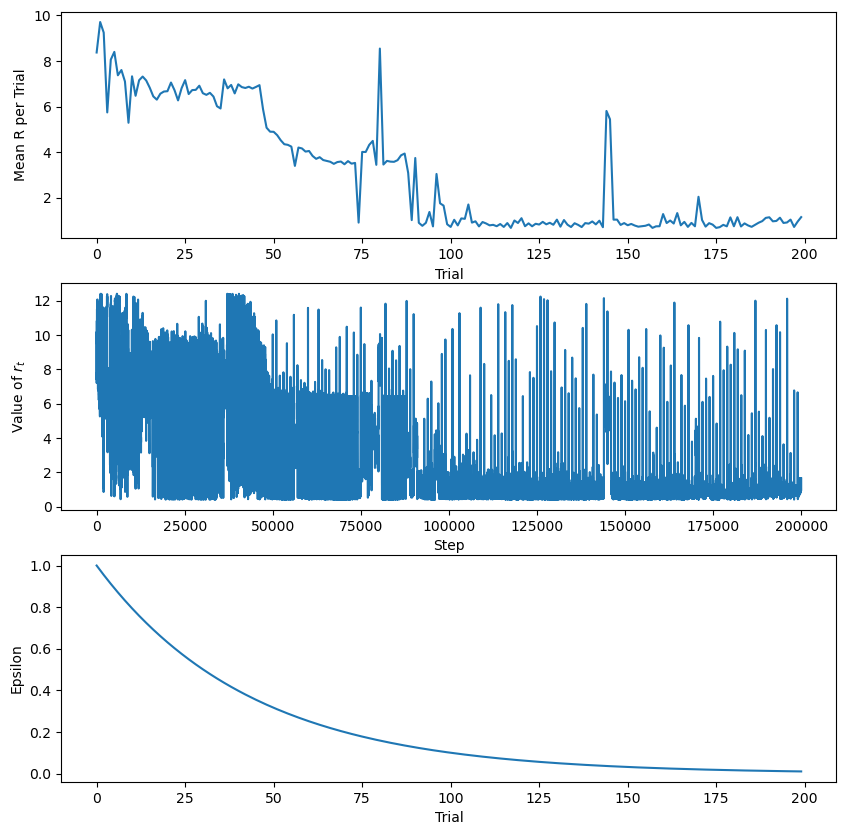

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.clf()
plt.subplot(3, 1, 1)
plt.plot(r_mean_trace)
plt.xlabel('Trial')
plt.ylabel('Mean R per Trial')

plt.subplot(3, 1, 2)
plt.plot(r_trace)
plt.xlabel('Step')
plt.ylabel('Value of $r_t$')

plt.subplot(3, 1, 3)
plt.plot(epsilon_trace)
plt.xlabel('Trial')
plt.ylabel('Epsilon');

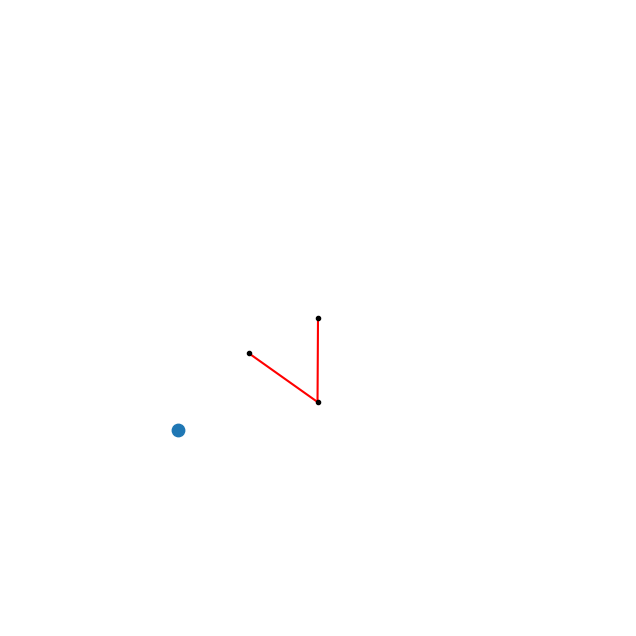

In [39]:
import numpy as np
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet)

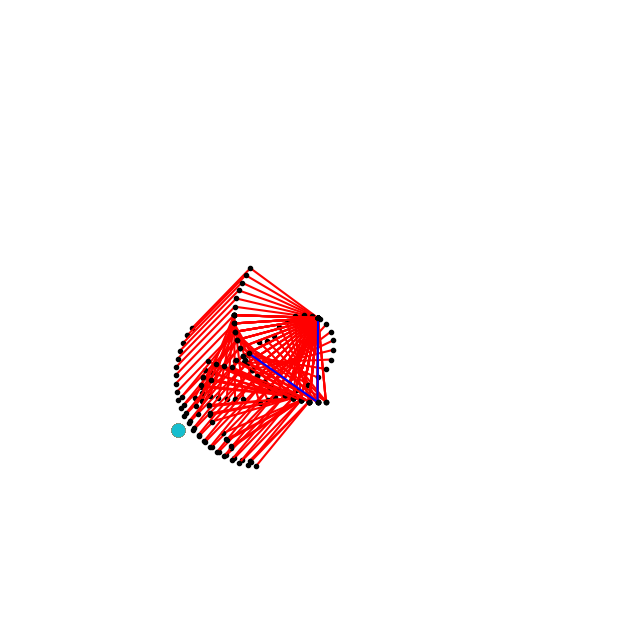

In [40]:
np.random.seed(1234)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

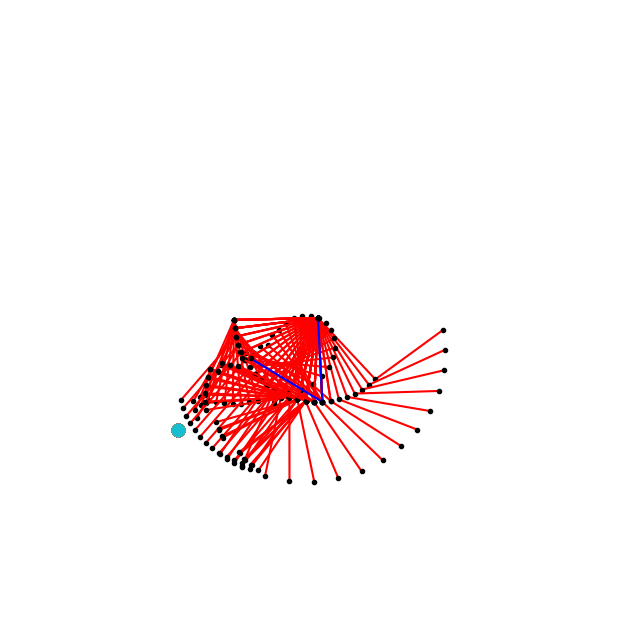

In [41]:
np.random.seed(4444)
initial_state(robot)
robot.animate(100, Qnet, show_all_steps=True)

# Required Experiments

Show the results and discuss what you see. Which parameter values result in the best performance during and at the end of training?

## Good parameter values

Find values for parameters `n_hiddens_list`, `n_trials`, `n_steps_per_trial`, `n_scg_iterations`, and `gamma` that result in Mean R per Trial plot that shows fairly steady decrease to value close to 0. 

import itertools

list_n_trials = 200
list_n_steps_per_trial = 1000
list_n_scg_iterations = 4
list_final_epsilon = 0.01
list_gamma = 0.9
list_n_hiddens_lists = [[100, 50, 10, 5], [100, 50, 10, 5]]

np.random.seed(42)
Qnet, r_mean_trace, r_trace, epsilon_trace = train(robot, n_hiddens_list, valid_actions, n_trials,
                                                   n_steps_per_trial, n_scg_iterations,
                                                   final_epsilon, gamma)

## Create robot with four links of lengths, 4, 3, 3,  and 2.

Again, find good values for the parameters. 

## Increase number of valid actions

We have been using just three different actions for each joint, `[-0.1, 0, 0.1]`.  Allow more precision in the control by changing this list of valid actions for each joint to `[-0.1, -0.05, 0, 0.05, 0.1]`.

As before, find good values for the parameters.

# Extra Credit

Earn 1 extra credit point by done one of the following two options, or do both of them for 2 extra credit points

1. Modify the code to be in the modular form discussed in class.  Your `Robot` class should extend `Environment` and define class `Qnet` that extends `Agent`.  Demonstrate that this new code works.
2. As discussed in class for the marble control, make modifications to allow a variable goal.  Add the goal coordinates to the state input to the Qnet.  Demonstrate success by plotting `r_mean_trace` for four different, fixed, goals.

